In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.tree import plot_tree

In [53]:
def generate_sample(N = 30):
    # generate a sample of size N = 30, with two classes and 5 features 
    # each having a standard Gaussian distribution with pairwise correlation 0.95
    num_features = 5
    corr_matrix = np.ones((num_features, num_features)) * 0.95 + np.identity(num_features) * 0.05
    X = np.random.multivariate_normal(mean=np.zeros(num_features), cov=corr_matrix, size=N)

    # The response Y was generated according to Pr(Y = 1|x1 ≤ 0.5) = 0.2, Pr(Y = 1|x1 > 0.5) = 0.8
    # what is the lowest possible error rate?
    Y = np.zeros(N)
    for i in range(N):
        if X[i,0] <= 0.5: # 80% to be 0
            Y[i] = np.random.binomial(1, 0.2)
        else: # 80% to be 1
            Y[i] = np.random.binomial(1, 0.8) 

    return X, Y

X_train, y_train = generate_sample(N = 40) # we need some variabiliy in the data for bootstrap to work
X_test, y_test = generate_sample(N = 2000)

treeclf = DecisionTreeClassifier(random_state=1)
treeclf.fit(X_train, y_train)
y_train_pred = treeclf.predict(X_train)
y_pred = treeclf.predict(X_test)
print('The accuracy on training data is {:.2f}'.format(accuracy_score(y_train, y_train_pred)))
print('The accuracy on test data is {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('The test error rate is {:.2f}'.format(1 - accuracy_score(y_test, y_pred)))

The accuracy on training data is 1.00
The accuracy on test data is 0.66
The test error rate is 0.34


40

Training an Ensemble model: train different independent models on slightly different subsets of data
* How to make each model independent with others? 
* Hint: The way the data is fed into the models can be challenging

## Bagging
* Trained Multiple Models on Bootstrap datasets
    + Bootstrap: Resampling the same size of sample with replacement; reduce variance
    + Bagging (or Bootstrap aggregation): agggregate the prediction over a collection of bootstrap samples
    + A Bootstrap sample $\mathbf{Z}^{* b}, b=1,2, \ldots, B$ -> a fitted model $\hat{f}^{* b}(x)$
        $$\hat{f}_{\mathrm{bag}}(x)=\frac{1}{B} \sum_{b=1}^B \hat{f}^{* b}(x)$$

Bagging Inference
* Voting for classification: $\hat{G}_{\text {bag }}(x)=\arg \max _k \hat{f}_{\mathrm{bag}}(x)$
    + "It is tempting to treat the voting proportions pk(x) as estimates of these probabilities. A simple two-class example shows that they fail in this regard." (Hastie, 2008) **How/why fails?**
     <!--  Suppose the true probability of class 1 at x is 0.75, and each of the bagged classifiers accurately predict a 1. Then p1(x) = 1, which is incorrect. -->
    + "An alternative bagging strategy is to average these instead, rather than the vote indicator vectors."
* Averaging for regression 
* Out-of-bag samples: about 1/3 original data is not in the bootstrap dataset which can be used for model evaluation

Goal: reduce the variance of unstable (high variance) learning methods. Assuming that the variables are simply i.d. (identically distributed, but not necessarily independent) with positive pairwise correlation ρ, the variance
of the average is
\begin{equation}
\rho \sigma^2+\frac{1-\rho}{B} \sigma^2
(\#eq:variance)
\end{equation}

<!-- Question 1: Which learning model/method is ideal for bagging?

Question 2: Will it reduce bias?

"since each tree generated in bagging is [identically distributed (i.d.)](https://stats.stackexchange.com/questions/89036/why-the-trees-generated-via-bagging-are-identically-distributed#:~:text=Bagging%20technique%20uses%20bootstraps%20\(random,population%20as%20the%20original%20sample.), the expectation of an average of B such trees is the same as the expectation of any one of them. This means the bias of bagged trees is the same as that of the individual trees, and the only hope of improvement is through variance reduction. This is in contrast to boosting, where the trees are grown in an adaptive way to remove bias, and hence are not i.d." (Hastie, 2008) -->




In [58]:
# bootstrap sample
def boostrap(X, y):
    X_boot = []
    y_boot = []
    for i in range(X.shape[0]):
        idx = np.random.randint(0, len(X_train))
        X_boot.append(X[idx])
        y_boot.append(y[idx])
    return X_boot, y_boot

# generate 200 bootstrap samples
bootstrap_samples = []
bootstrap_labels = []
for _ in range(2000):
    X_boot, y_boot = boostrap(X_train, y_train)
    bootstrap_samples.append(X_boot)
    bootstrap_labels.append(y_boot)


# fit an ensemble of classification trees
ensemble_clf = []
for i in range(2000):
    ensemble_clf.append(DecisionTreeClassifier(random_state=1, max_features=2).fit(bootstrap_samples[i], bootstrap_labels[i]))

# predict the test data
y_preds = []
for clf in ensemble_clf:
    y_preds.append(clf.predict(X_test))
y_pred = (np.array(y_preds).mean(axis=0) > 0.5).astype(int)

y_train_preds = []
for clf in ensemble_clf:
    y_train_preds.append(clf.predict(X_train))
y_train_pred = (np.array(y_train_preds).mean(axis=0) > 0.5).astype(int)

print('The accuracy on training data is {:.2f}'.format(accuracy_score(y_train, y_train_pred)))
print('The accuracy on test data is {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('The test error rate is {:.2f}'.format(1 - accuracy_score(y_test, y_pred)))

The accuracy on training data is 1.00
The accuracy on test data is 0.70
The test error rate is 0.30


<center><img src="pics/bagging.png" width="500"></center>

<center><img src="pics/bagging_result.png" width="500"></center>

* the trees have high variance due to the correlation in the predictors
* Bagging succeeds in smoothing out this variance and hence reducing the test error
    + " averaging reduces variance and leaves bias unchanged" (Hastie, 2008)

## [Random Forest](https://link.springer.com/article/10.1023/A:1010933404324)
* "the size of the correlation of pairs of bagged trees limits the benefits of averaging" according to Formula 1
* "a substantial modification of bagging that builds a large collection of de-correlated trees"
* Iteratively 1) make a bootstrapped dataset; 2) only use a random subset of variables at each splitting (`max_features`)
* can handle large data sets with higher dimensionality (thousands of input variables).
* can identify most significant variables

In [59]:
n_estimators = 200 
rf_clf = RandomForestClassifier(n_estimators=n_estimators, criterion="gini", max_features=None) #  max_depth=5,
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print('The accuracy on training data is {:.2f}'.format(rf_clf.score(X_train, y_train)))
print('The accuracy on test data is {:.2f}'.format(rf_clf.score(X_test, y_test)))
print('The test error rate is {:.2f}'.format(1 - rf_clf.score(X_test, y_test)))


# for estimator in rf_clf.estimators_:
#     plt.figure(figsize=(12,12))
#     tree.plot_tree(estimator, filled=True, rounded=True)
#     plt.show()


The accuracy on training data is 1.00
The accuracy on test data is 0.69
The test error rate is 0.31


[Looking for good `n_estimators`](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)

## Boosting
What to boost?

* AdaBoost
    + an fix-sized estimator uses only one feature, i.e., one stump (one root node with two leaf nodes)
    + weak learner
    + build the subsequent stumps using the residuals
    + the amount of say 
        $$\alpha_m=\log \left(\left(1-\operatorname{err}_m\right) / \operatorname{err}_m\right)$$

    + Update the weights
        $$w_i \cdot \exp \left[\alpha_m \cdot I\left(y_i \neq G_m\left(x_i\right)\right)\right], i=1,2, \ldots, N$$
<!-- Emphasize the need to correctly classify the examples with wrong predictions in the previous steps -->

In [130]:
# build an Adaboost classifier with 200 trees
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
print('The accuracy on training data is {:.2f}'.format(ada_clf.score(X_train, y_train)))
print('The accuracy on test data is {:.2f}'.format(ada_clf.score(X_test, y_test)))
print('The test error rate is {:.2f}'.format(1 - ada_clf.score(X_test, y_test)))
print(classification_report(y_test, y_pred))


The accuracy on training data is 1.00
The accuracy on test data is 0.69
The test error rate is 0.31
              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73      1197
         1.0       0.61      0.66      0.63       803

    accuracy                           0.69      2000
   macro avg       0.68      0.69      0.68      2000
weighted avg       0.70      0.69      0.69      2000




* GradientBoost
    + an fixeds-size estimator normally has 8 to 32 leaves
    + iteratively fit residuals by a split
    + use learning rate to avoid high bias
    + [Youtube Course](vhttps://www.youtube.com/watch?v=3CC4N4z3GJc)

In [35]:
# Load the data
data = pd.read_csv('data/sample_dataset.csv')

# Split into train and test
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
target_col = train_data.columns[-1]
X_train = train_data.drop(target_col, axis=1)
X_train = X_train.iloc[:, 2:] # remove the first two columns: subject ID and sample ID
X_test = test_data.drop(target_col, axis=1)
X_test = X_test.iloc[:, 2:]
y_train = train_data[target_col]
y_test = test_data[target_col]

model = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('The mean squared error on test data is {:.2f}'.format(mean_squared_error(y_test, y_pred)))


The mean squared error on test data is 0.13


In [36]:

model = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('The mean squared error on test data is {:.2f}'.format(mean_squared_error(y_test, y_pred)))


The mean squared error on test data is 0.13


In [ ]:
class GradientBoostingRegressor:
    def __init__(self, n_estimators=100, max_depth=3, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.models = []
        
    def fit(self, X, y):
        # Initialize the residuals
        
        for i in range(self.n_estimators):
        
            # Fit a decision tree to the negative gradient of the loss function
            residual = y_test - y_pred
            fit(X, residual)
            # Add the new tree to the ensemble
         

            # calculate current residuals
            
            
    def predict(self, X):
        # Initialize the predictions to be self.init_pred
  
        # Iterate over each decision tree in the ensemble and make predictions
        
    


<center><img src="pics/gradient-boost1.png" width="500"></center>

<center><img src="pics/gradient-boost2.png" width="500"></center>

In [131]:
# build a Gradient Boosting classifier with 200 trees
gb_clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.5, max_depth=1, random_state=0)
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)
print('The accuracy on training data is {:.2f}'.format(gb_clf.score(X_train, y_train)))
print('The accuracy on test data is {:.2f}'.format(gb_clf.score(X_test, y_test)))
print('The test error rate is {:.2f}'.format(1 - gb_clf.score(X_test, y_test)))
print(classification_report(y_test, y_pred))



The accuracy on training data is 1.00
The accuracy on test data is 0.69
The test error rate is 0.31
              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73      1197
         1.0       0.60      0.66      0.63       803

    accuracy                           0.69      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.69      0.69      0.69      2000



In [ ]:
# # read titanic data
# titanic_df = pd.read_csv('data/titanic_cleaned_data.csv')
# print(titanic_df.columns)
# # define X and y
# # Port of Embarkation: Q = Queenstown, S = Southampton
# feature_cols = ['Pclass', 'Sex', 'Embarked_Q', 'Embarked_S', 'Age', 'PassengerId']
# X = titanic_df[feature_cols]
# y = titanic_df.Survived
# X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
# ## Finding Important Features
# importances = rf_clf.feature_importances_
# print(importances)
# forest_importances = pd.Series(importances, index=list(X_train.columns))
# std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)
# print(forest_importances.head())

# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=std, ax=ax)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

## Pass Activity

In [7]:
# Q1: Load HR-Employee-Attrition.csv dataset and 
# create an ensemble ML model for predicting target variable (Attrition). 
# Report the performance of the model using appropriate metrics.
def load_data():
    df = pd.read_csv("data/HR-Employee-Attrition.csv")
    df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis="columns", inplace=True)
    categorical_col = []
    for column in df.columns:
        if df[column].dtype == object and len(df[column].unique()) <= 50:
            categorical_col.append(column)
    print(f'The {len(categorical_col)} features will be used: {categorical_col}.')
    print('The values for Attrition column are: ')
    print(df.Attrition.value_counts())
    df['Attrition'] = df.Attrition.astype("category").cat.codes
    print('The Attrition column has been encoded. The values are: ')
    print(df.Attrition.value_counts())
    
    return df

df = load_data()
categorical_col = []
for column in df.columns:
    if df[column].dtype == object:
        assert len(df[column].unique()) <= 50
        categorical_col.append(column)
        df[column] = df[column].astype("category").cat.codes

df.head()

The 8 features will be used: ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime'].
The values for Attrition column are: 
No     1233
Yes     237
Name: Attrition, dtype: int64
The Attrition column has been encoded. The values are: 
0    1233
1     237
Name: Attrition, dtype: int64


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,2,1102,2,1,2,1,2,0,...,3,1,0,8,0,1,6,4,0,5
1,49,0,1,279,1,8,1,1,3,1,...,4,4,1,10,3,3,10,7,1,7
2,37,1,2,1373,1,2,2,4,4,1,...,3,2,0,7,3,3,0,0,0,0
3,33,0,1,1392,1,3,4,1,4,0,...,3,3,0,8,3,3,8,7,3,0
4,27,0,2,591,1,2,1,3,1,1,...,3,4,1,6,3,3,2,2,2,2


In [8]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5)

X_train, X_test, y_train, y_test = train_test_split(df.drop('Attrition', axis=1), df.Attrition, test_size=0.3, random_state=42)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
print(classification_report(y_test, pred))
print(classification_report(y_train, rf_clf.predict(X_train)))


              precision    recall  f1-score   support

           0       0.87      0.99      0.93       380
           1       0.60      0.10      0.17        61

    accuracy                           0.87       441
   macro avg       0.74      0.54      0.55       441
weighted avg       0.83      0.87      0.82       441

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       853
           1       1.00      0.30      0.46       176

    accuracy                           0.88      1029
   macro avg       0.94      0.65      0.69      1029
weighted avg       0.89      0.88      0.85      1029



In [10]:
# Q2: Have you used any hyperparameter tuning while building the model in Q1? 
# If so then plot your performance metrics for different hyperparmeter values that you have used in Q1.  Hints
# HyperParameter tuning from : https://datagy.io/sklearn-decision-tree-classifier
params = {
    'criterion':  ['gini'],  # 'criterion':  ['gini', 'entropy', 'log_loss'],
    'n_estimators':  list(range(5, 150, 1)),
    # 'max_depth':  [None, 2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    # 'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8]
}

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

clf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
    scoring=scoring,
    refit="AUC"
)

clf.fit(X_train, y_train)
print('Best Hyperparameters setting: \n{}\n'.format(clf.best_params_))
print('Best Hyperparameters setting scorer: {}'.format(scoring))
print('Best Hyperparameters setting score: {}'.format(clf.best_score_))

clf_results = clf.cv_results_
pd_cld = pd.DataFrame(clf.cv_results_)
pd_cld.head(5)




Fitting 5 folds for each of 145 candidates, totalling 725 fits
Best Hyperparameters setting: 
{'criterion': 'gini', 'n_estimators': 89}

Best Hyperparameters setting scorer: {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
Best Hyperparameters setting score: 0.8191200550395596


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,...,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
0,0.061724,0.011911,0.040104,0.007242,gini,5,"{'criterion': 'gini', 'n_estimators': 5}",0.717293,0.705514,0.711111,...,0.835771,0.028493,144,0.982989,0.974484,0.973269,0.974484,0.979369,0.976919,0.003689
1,0.090537,0.023187,0.034142,0.008135,gini,6,"{'criterion': 'gini', 'n_estimators': 6}",0.725647,0.713617,0.662907,...,0.841601,0.014192,142,0.967193,0.962333,0.959903,0.968408,0.967233,0.965014,0.003302
2,0.083861,0.021521,0.030166,0.002428,gini,7,"{'criterion': 'gini', 'n_estimators': 7}",0.726483,0.696491,0.738346,...,0.842576,0.020425,141,0.980559,0.989064,0.984204,0.987849,0.984223,0.985180,0.003014
3,0.064072,0.004579,0.024427,0.003431,gini,8,"{'criterion': 'gini', 'n_estimators': 8}",0.719632,0.679282,0.732581,...,0.840644,0.019838,143,0.980559,0.973269,0.987849,0.979344,0.969660,0.978136,0.006280
4,0.059384,0.002266,0.022963,0.002675,gini,9,"{'criterion': 'gini', 'n_estimators': 9}",0.717126,0.830911,0.684712,...,0.856188,0.011549,19,0.992710,0.990279,0.992710,0.989064,0.986650,0.990283,0.002300


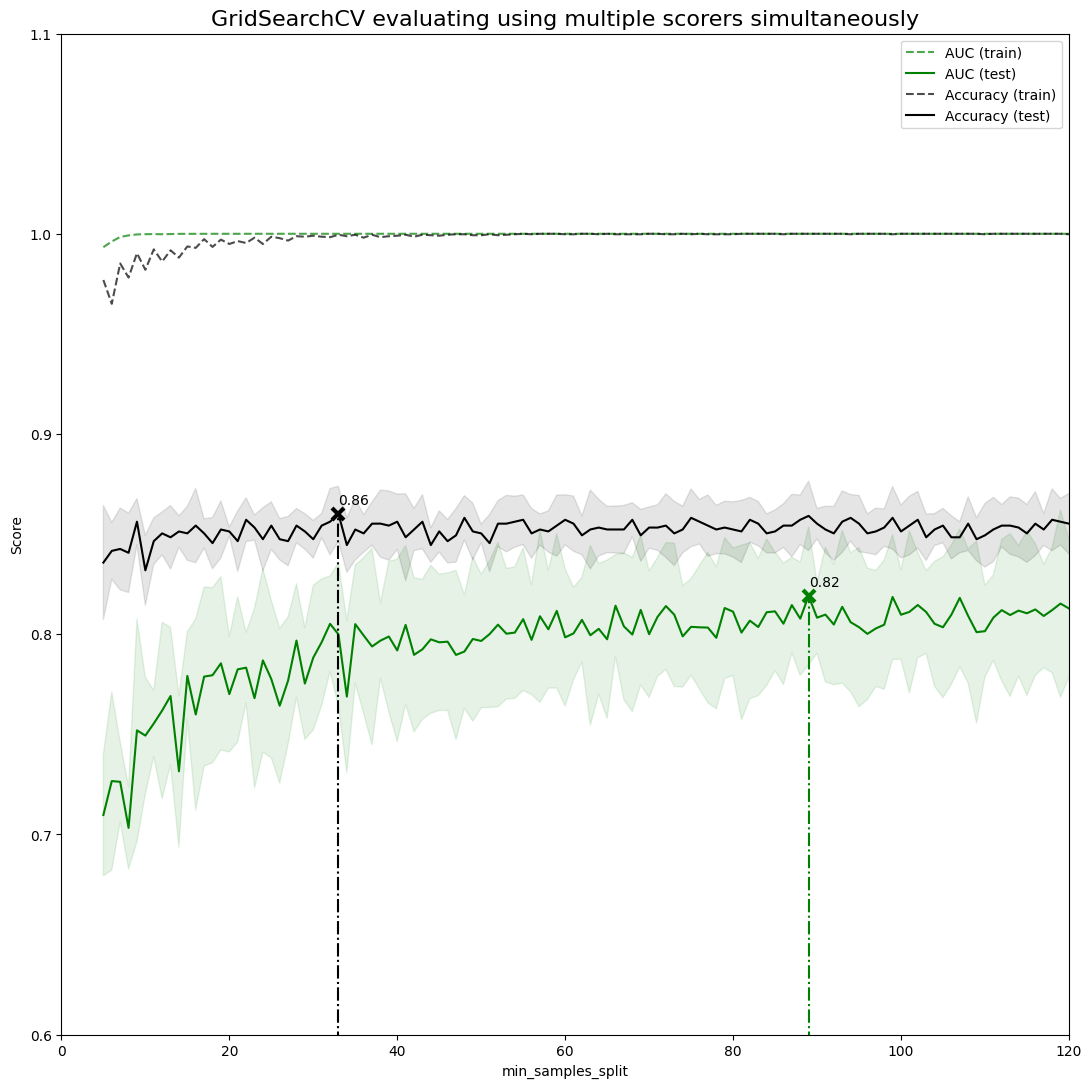

In [11]:
def hyperplot(results, scoring):
    plt.figure(figsize=(13, 13))
    plt.title("GridSearchCV evaluating using multiple scorers simultaneously", 
              fontsize=16)

    plt.xlabel("min_samples_split")
    plt.ylabel("Score")

    ax = plt.gca()
    ax.set_xlim(0, 120)
    ax.set_ylim(0.6, 1.1)

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results["param_n_estimators"].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ["g", "k"]):
        for sample, style in (("train", "--"), ("test", "-")):
            sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
            sample_score_std = results["std_%s_%s" % (sample, scorer)]
            ax.fill_between(
                X_axis,
                sample_score_mean - sample_score_std,
                sample_score_mean + sample_score_std,
                alpha=0.1 if sample == "test" else 0,
                color=color,
            )
            ax.plot(
                X_axis,
                sample_score_mean,
                style,
                color=color,
                alpha=1 if sample == "test" else 0.7,
                label="%s (%s)" % (scorer, sample),
            )

        best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
        best_score = results["mean_test_%s" % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot(
            [
                X_axis[best_index],
            ]
            * 2,
            [0, best_score],
            linestyle="-.",
            color=color,
            marker="x",
            markeredgewidth=3,
            ms=8,
        )

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()
hyperplot(clf_results, scoring)

In [ ]:
# Q3: Reflect on the importance of hyperparameter tuning of ML models based on your ML model development exercise. 


In [ ]:

# 4. Create a GradientBoost model for the predicting Attrition using the same dataset that you have used Q1 and report the performance.
params = {
    'n_estimators':  list(range(5, 150, 1))
}

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

gb_clf = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid=params,
    cv=5,
    n_jobs=-1,d
    verbose=1,
    return_train_score=True,
    scoring=scoring,
    refit="AUC"
)

gb_clf.fit(X_train, y_train)
print('Best Hyperparameters setting: \n{}\n'.format(gb_clf.best_params_))
print('Best Hyperparameters setting scorer: {}'.format(scoring))
print('Best Hyperparameters setting score: {}'.format(gb_clf.best_score_))

# Plot your performance metrics fpr different hyperparameter values.
gb_clf_results = gb_clf.cv_results_
pd_cld = pd.DataFrame(gb_clf.cv_results_)

hyperplot(gb_clf_results, scoring)

# 5. Compare the performance of two models (Q1 and Q3). Explain which model is good and why.